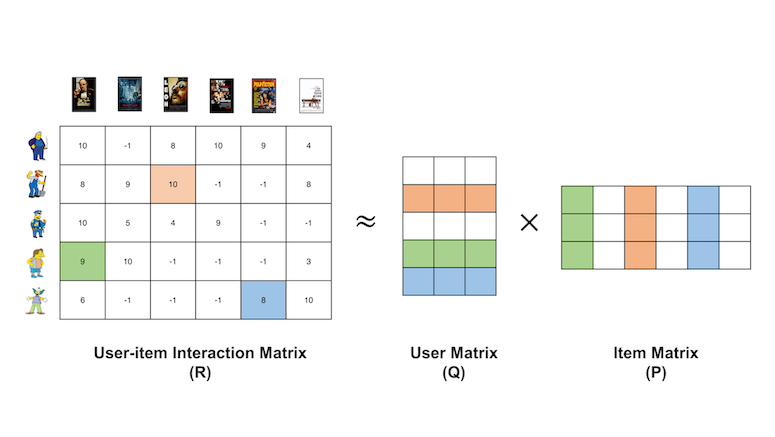

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import warnings

warnings.filterwarnings('ignore')

In [2]:
!gdown 1Q9UJtrN_v_dS-garl5gQ1I_SotGhye_1
!gdown 1HOFWUAMFlYbd-gk1B2IyV2-hXDZI7gKR
!gdown 1b7_yRRBs3s3atp1WQHN2GU577vxY8u_h

Downloading...
From: https://drive.google.com/uc?id=1Q9UJtrN_v_dS-garl5gQ1I_SotGhye_1
To: /content/movies.csv
100% 516k/516k [00:00<00:00, 6.80MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HOFWUAMFlYbd-gk1B2IyV2-hXDZI7gKR
To: /content/ratings.csv
100% 2.48M/2.48M [00:00<00:00, 131MB/s]
Downloading...
From: https://drive.google.com/uc?id=1b7_yRRBs3s3atp1WQHN2GU577vxY8u_h
To: /content/users.csv
100% 16.8k/16.8k [00:00<00:00, 40.9MB/s]


In [9]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

Top 1000 popular movies

In [11]:
selected_movies = ratings['movieId'].value_counts()[:1000].index.to_list()
movies = movies.loc[movies.movieId.isin(selected_movies)]
ratings = ratings.loc[ratings.movieId.isin(selected_movies)]

In [12]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [13]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246


In [14]:
movies.shape, ratings.shape

((1000, 3), (63250, 4))

# Code and Model

**Interaction Matrix**

In [16]:
rm = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
rm.head()

movieId,1,2,3,5,6,7,10,11,16,17,...,88125,89745,91529,96610,99114,109374,109487,111759,112852,116797
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,3.0,0.0,3.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
rm.shape

(668, 1000)

**Sparsity**

In [19]:
(rm > 0).sum().sum() / (rm.shape[0] * rm.shape[1])

np.float64(0.09468562874251497)

As from scratch the implementation is a bit inefficient we only take a subset of the matrix

In [20]:
rm_small = rm.copy()
rm_small = rm_small[rm_small.columns[:100]]
rm_small = rm_small.head(100)

In [21]:
rm_small.shape

(100, 100)

**Matrix Factorisation Implementation**

R = rm_small

R = P x Q(T)

In [27]:
K = 2 # d embeddings

In [51]:
def matrix_factorisation(R, K, alpha=0.01, steps=100):

  # initialising the P and Q matrix

  P = np.random.normal(size=(R.shape[0], K))
  Q = np.random.normal(size=(R.shape[1], K))

  Q = Q.T
  for step in range(steps):
    for i in range(R.shape[0]):
      for j in range(R.shape[1]):

        if R[i][j] == 0:
          continue

        # the error element or the derivatives

        e_ij = np.dot(P[i,:],Q[:,j]) - R[i][j]

        for k in range(K):
          P[i][k] = P[i][k] - alpha * e_ij * Q[k][j]
          Q[k][j] = Q[k][j] - alpha * e_ij * P[i][k]

  return P, Q.T


In [52]:
P_, Q_ = matrix_factorisation(R=rm_small.values.copy(), K=2)

In [53]:
P_.shape, Q_.shape

((100, 2), (100, 2))

In [57]:
# rating prediction for u4, I17
np.dot(P_[3], Q_[17])

np.float64(4.786542189591185)

In [58]:
rm_small.iloc[3,17]

np.float64(5.0)

In [59]:
rm_ = np.dot(P_, Q_.T)

In [60]:
rm_.shape

(100, 100)

# Final Evaluation

In [63]:
from sklearn.metrics import mean_squared_error as mse

In [64]:
mse(rm_small.values[rm_small>0], rm_[rm_small>0]) **0.5

0.7040245391412641

On an average ratings are 0.7 units away from actual rating